# Visualizing Damage Estimation in Gaza

This Jupyter Notebook aims to provide a visual analysis of Synthetic Aperture Radar (SAR) data to assess and visualize potential damage in the Gaza Strip. SAR data, known for its ability to capture ground features and changes regardless of weather conditions or time of day, can be instrumental in identifying changes in infrastructure or land features following conflict or disasters.

```{caution}
The following damage assessment figures are based on preliminary estimates and have not been verified through field survey or satellite imagery. They do not reflect the final estimations by the [World Bank](https://www.worldbank.org/en/country/westbankandgaza).
```

```{note}
The results shown in this analysis only reflect the damages until **November 22nd 2023**. As the team completes further analysis, the notebook will be updated. 
```

## Damage Assessment Map

You can now interact with this map by selecting/deselecting different damage layers to visualize where buildings are most impacted in the Gaza Strip. Upon visual inspection, you can see:

1. **Damage:** You can select and deselect the layers to see damages to roads, buildings and points of interest. The damage value ranges between 0 and 1 with 1 indicating higher levels of damage.
2. **Conflict:** You can select this layer to view areas wit reported events and fatalities.

<iframe width="100%" height="500px" src="https://studio.foursquare.com/public/26ba3dfb-0770-4cc6-b6fa-2ee2878580fc/embed" frameborder="0" allowfullscreen></iframe>

```{figure} ../../docs/images/logo.png
---
height: 0px
---
Damage assessment in the Gaza Strip utilizing SAR imagery to evaluate the extent of destruction The damage map above is based on preliminary estimates and have not been verified through field survey or satellite imagery. It does not reflect the final estimations by the World Bank. Country borders or names do not necessarily reflect the World Bank Group's official position. This map is for illustrative purposes and does not imply the expression of any opinion on the part of the World Bank, concerning the legal status of any country or territory or concerning the delimitation of frontiers or boundaries.
```

## Summary Statistics

In the following section, we calculate summary statistics for each second-level administrative division. 

In [1]:
#!pip install pandas geopandas openpyxl

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FuncFormatter
from palettable.tableau import ColorBlind_10, TableauMedium_10
from palettable.cartocolors.qualitative import Prism_10, Vivid_10

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [3]:
# read aggregated damage assessment files
damage_assessment_totals = pd.read_excel(
    "../../data/damage_assessment/delivery4_22Nov2023/Gaza_damage_22Nov2023.xlsx"
).rename(columns={"Unnamed: 0": "ADM2_EN", "Province": "ADM2_EN"}, inplace=True)

damage_assessment_buildings = pd.read_excel(
    "../../data/damage_assessment/delivery4_22Nov2023/Gaza_damage_22Nov2023.xlsx",
    sheet_name="buildings",
).rename(columns={"Unnamed: 0": "ADM2_EN", "Province": "ADM2_EN"})

#
damage_assessment_buildings["%"] *= 100

damage_assessment_pois = pd.read_excel(
    "../../data/damage_assessment/delivery4_22Nov2023/Gaza_damage_22Nov2023.xlsx",
    sheet_name="pois_a",
).rename(columns={"Unnamed: 0": "ADM2_EN", "Province": "ADM2_EN"})

damage_assessment_roads = pd.read_excel(
    "../../data/damage_assessment/delivery4_22Nov2023/Gaza_damage_22Nov2023.xlsx",
    sheet_name="roads",
).rename(columns={"Unnamed: 0": "ADM2_EN", "Province": "ADM2_EN"})

In [4]:
# read shapefiles
palestine = gpd.read_file(
    "../../data/boundaries/pse_adm_pamop_20231019_shp/pse_admbnda_adm1_pamop_20231019.shp"
)
gaza = palestine[palestine["ADM1_EN"] == "Gaza Strip"]
gaza_adm2 = gpd.read_file(
    "../../data/boundaries/pse_adm_pamop_20231019_shp/pse_admbnda_adm2_pamop_20231019.shp"
)

### Buildings

In the following section, we calculate summary statistics on **Buildings** for each second-level administrative division. 

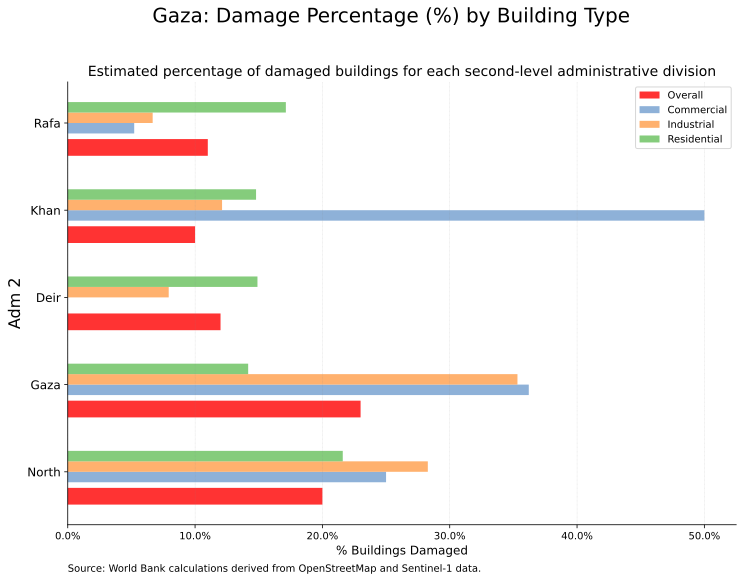

In [5]:
df = damage_assessment_buildings.set_index("ADM2_EN")[0:-1]
df.rename(
    columns={
        "%": "Overall",
        "% resid. damaged": "Residential",
        "% industr. damaged": "Industrial",
        "% comm. damaged": "Commercial",
    },
    inplace=True,
)
columns = ["Overall", "Commercial", "Industrial", "Residential"]

df1 = df[columns].stack().reset_index()
df1.rename(columns={"level_1": "damage_type", 0: "damage_percentage"}, inplace=True)

fig, ax = plt.subplots(figsize=(12, 8))
plt.suptitle("Gaza: Damage Percentage (%) by Building Type", y=1.01, fontsize=20)

# Number of groups and categories
n_groups = df1["ADM2_EN"].nunique()
n_categories = df1["damage_type"].nunique()

# Bar parameters
bar_width = 0.12
opacity = 0.8
index = np.arange(n_groups)

colors = TableauMedium_10.mpl_colors
colors.insert(0, "red")

# Plotting bars for each category
for i, (category, color) in enumerate(zip(columns, colors)):
    category_values = df1[df1["damage_type"] == category]["damage_percentage"].values
    if i == 0:
        ax.barh(
            -0.1 + index + i * 1.6 * bar_width,
            category_values,
            1.6 * bar_width,
            alpha=opacity,
            label=category,
            color=color,
        )
    else:
        ax.barh(
            index + i * bar_width,
            category_values,
            bar_width,
            alpha=opacity,
            label=category,
            color=color,
            align="center",
        )

# Add labels and customization
ax.set_xlabel("% Buildings Damaged", fontsize=12)

ax.set_ylabel("Adm 2", fontsize=16)
ax.set_yticks(index + bar_width * (n_categories - 1) / 2)
ax.set_yticklabels(df1["ADM2_EN"].unique(), fontsize=12)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{}%".format(y)))

ax.grid(axis="x", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
ax.legend()

ax.set_title(
    "Estimated percentage of damaged buildings for each second-level administrative division",
    fontsize=14,
)
ax.text(
    0,
    -0.1,
    "Source: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
);

Alternatively, please see below the tabular data.

In [6]:
df.style.format(
    {
        "Overall": "{:,.2f}%",
        "Residential": "{:,.2f}%",
        "Industrial": "{:,.2f}%",
        "Commercial": "{:,.2f}%",
    },
    precision=0,
)

,Tot. buildings,Tot. damaged,Overall,Residential buildings,Residential damaged buildings,Residential,Industrial buildings,Industrial damaged buildings,Industrial,Commercial buildings,Commercial damaged buildings,Commercial
ADM2_EN,,,,,,,,,,,,
North,29714,6022,20.00%,10060,2173,21.60%,10060,2173,28.28%,10060,2173,25.00%
Gaza,43617,10236,23.00%,127,18,14.17%,127,18,35.32%,127,18,36.21%
Deir,30382,3564,12.00%,7327,1092,14.90%,7327,1092,7.93%,7327,1092,0.00%
Khan,43619,4544,10.00%,19375,2865,14.79%,19375,2865,12.12%,19375,2865,50.00%
Rafa,26507,3034,11.00%,2359,404,17.13%,2359,404,6.67%,2359,404,5.22%


```{figure} ../../docs/images/logo.png
---
height: 0px
---
Absolute and percentage damage assessment estimation for each second-level administrative division (row) and building type (column).
```

### Points of Interest

In the following section, we calculate summary statistics on **Points of Interest** for each second-level administrative division. 

In [7]:
def get_poi_classification(poi):
    if poi in [
        "School",
        "School_dam",
        "College",
        "College_dam",
        "Uni",
        "Uni_dam",
        "Kindergarden",
        "Kinder_dam",
        "schools",
        "colleges",
        "universities",
        "kindergardens",
        "% dam. chools",
        "% dam. colleges",
        "% dam. univ.",
        "% dam. kinder.",
        "damaged schools",
        "damaged colleges",
        "damaged universities",
        "damaged kindergardens",
        "schools",
        "damaged schools",
        "% dam. chools",
        "colleges",
        "damaged colleges",
        "% dam. colleges",
        "universities",
        "damaged universities",
        "% dam. univ.",
        "kindergardens",
        "damaged kindergardens",
        "% dam. kinder.",
    ]:
        return "Educational Institutions"
    elif poi.lower() in [
        "mall ",
        "mall_dam",
        "market_place",
        "market_dam",
        "department_store",
        "damaged dep_damage",
        "% dam. malls",
        "% dam. markets",
        "malls",
        "market places",
        "department stores",
        "damaged malls",
        "damaged market places",
        "damaged department stores",
        "malls",
        "damaged malls",
        "% dam. malls",
        "market places",
        "damaged market places",
        "% dam. markets",
        "department stores",
        "damaged department stores",
        "% dam. departm.",
    ]:
        return "Places of Economic Activity"
    elif poi.lower() in [
        "water_tower",
        "water_dam",
        "water towers",
        "damaged water towers",
        "% dam. departm.",
        "% dam. water",
        "water towers",
        "damaged water towers",
        "% dam. water",
    ]:
        return "Water Infrastructure"
    elif poi.lower() in [
        "communication towers",
        "damaged communication towers",
        "% dam. comms.",
    ]:
        return "Communications Infrastructure"
    else:
        return "Overall"


def get_damage_columns(x):
    if "%" in x.lower():
        return "Percentage"
    elif "damage" in x.lower():
        return "Damage"
    else:
        return "Total"

In [8]:
df = damage_assessment_pois.set_index("ADM2_EN").stack().reset_index()
df.rename(columns={"level_1": "building_type", 0: "number"}, inplace=True)
df["building_category"] = df["building_type"].apply(lambda x: get_poi_classification(x))
df["value_type"] = df["building_type"].apply(lambda x: get_damage_columns(x))

df = (
    df[["ADM2_EN", "building_category", "value_type", "number"]]
    .groupby(["ADM2_EN", "building_category", "value_type"])
    .sum()
    .reset_index()
    .pivot_table(index=["ADM2_EN", "building_category"], columns="value_type")
)
df.columns = [".".join(col).strip() for col in df.columns.values]

df["percentage_damage"] = 100 * df["number.Damage"] / df["number.Total"]
df = df.reset_index()

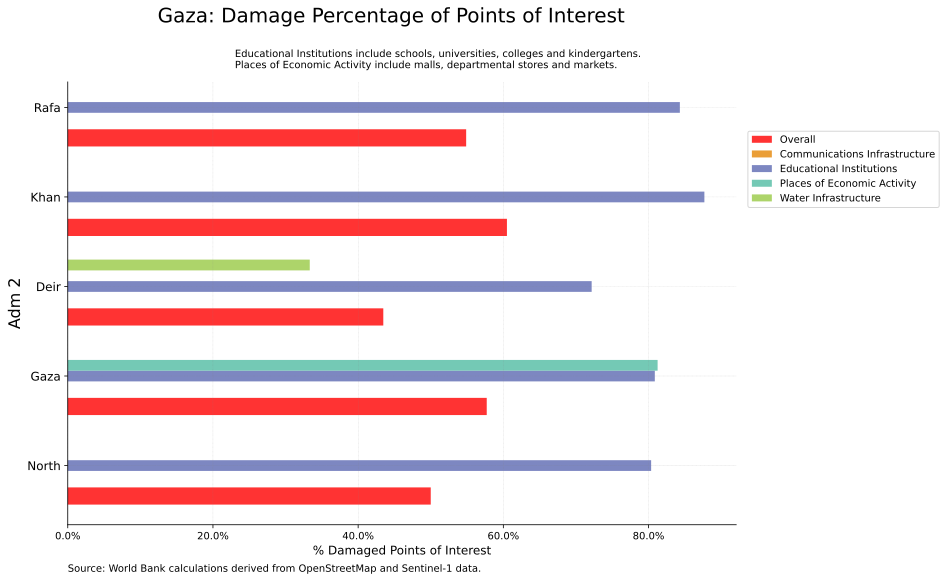

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.suptitle("Gaza: Damage Percentage of Points of Interest", y=1.01, fontsize=20)

# Number of groups and categories
n_groups = df["ADM2_EN"].nunique()
n_categories = df["building_category"].nunique()

# Bar parameters
bar_width = 0.12
opacity = 0.8
index = np.arange(n_groups)

# categories = list(df["building_category"].unique())
# categories.insert(0, categories.pop(categories.index("Overall")))
categories = [
    "Overall",
    "Communications Infrastructure",
    "Educational Institutions",
    "Places of Economic Activity",
    "Water Infrastructure",
]

colors = Vivid_10.mpl_colors
colors.insert(0, "red")

# Plotting bars for each category
for i, (category, color) in enumerate(zip(categories, colors)):
    category_values = df[df["building_category"] == category][
        "percentage_damage"
    ].values
    if i == 0:
        ax.barh(
            -0.1 + index + i * 1.6 * bar_width,
            category_values,
            1.6 * bar_width,
            alpha=opacity,
            label=category,
            color=color,
        )
    else:
        ax.barh(
            index + i * bar_width,
            category_values,
            bar_width,
            alpha=opacity,
            label=category,
            color=color,
        )
# Add labels and customization
ax.set_xlabel("% Damaged Points of Interest", fontsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{}%".format(y)))

ax.set_yticks(index + bar_width * (n_categories - 1) / 2)

ax.set_ylabel("Adm 2", fontsize=16)
ax.set_yticklabels(df1["ADM2_EN"].unique(), fontsize=12)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

ax.grid(which="both", linestyle="--", linewidth=0.25, color="gray", alpha=0.5)
ax.legend(bbox_to_anchor=(1.01, 0.9))

ax.text(
    0.25,
    1.05,
    "Educational Institutions include schools, universities, colleges and kindergartens.\nPlaces of Economic Activity include malls, departmental stores and markets.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
)

ax.text(
    0,
    -0.1,
    "Source: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
);

Alternatively, please see below the tabular data.

In [10]:
damage_assessment_pois

,ADM2_EN,Tot pois,Damaged pois,%,schools,damaged schools,% dam. chools,colleges,damaged colleges,% dam. colleges,...,% dam. markets,department stores,damaged department stores,% dam. departm.,water towers,damaged water towers,% dam. water,communication towers,damaged communication towers,% dam. comms.
0,North,243,147,60.49,55,52,94.55,3,2,66.67,...,0.00,0,0,0,2,0,0.00,0,0,0
1,Gaza,577,333,57.71,139,116,83.45,5,4,80.00,...,84.62,0,0,0,6,0,0.00,0,0,0
2,Deir,148,74,50.00,51,42,82.35,1,1,100.00,...,0.00,0,0,0,0,0,0.00,0,0,0
3,Khan,306,133,43.46,78,61,78.21,5,3,60.00,...,0.00,1,0,0,6,2,33.33,0,0,0
4,Rafa,164,90,54.88,48,41,85.42,0,0,0.00,...,0.00,0,0,0,0,0,0.00,0,0,0


```{figure} ../../docs/images/logo.png
---
height: 0px
---
Percentage damage assessment estimation for each second-level administrative division (row) and points of interest (column).
```

### Roads

In the following section, we calculate summary statistics on **Roads** for each second-level administrative division. 

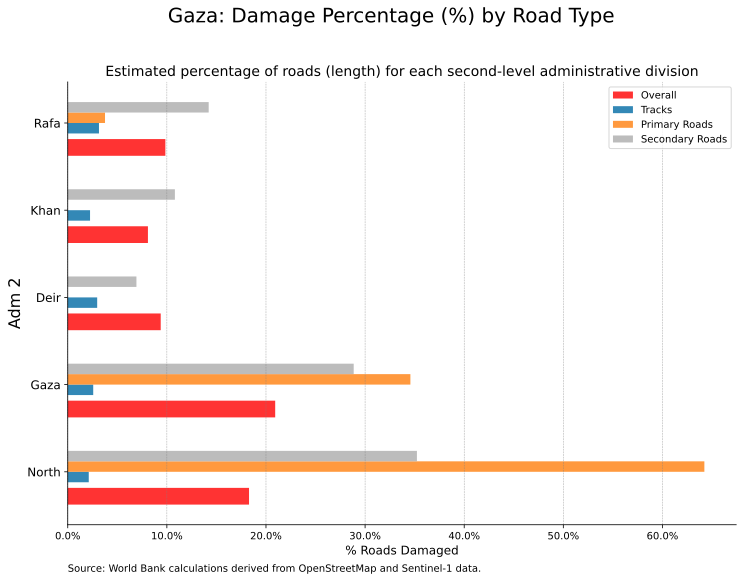

In [11]:
df = damage_assessment_roads.set_index("ADM2_EN")[
    ["% Tot", "% tracks", "% primaries", "% secondaries"]
]
df.rename(
    columns={
        "% Tot": "Overall",
        "% tracks": "Tracks",
        "% primaries": "Primary Roads",
        "% secondaries": "Secondary Roads",
    },
    inplace=True,
)

df1 = df.stack().reset_index()
df1.rename(columns={"level_1": "damage_type", 0: "damage_percentage"}, inplace=True)

fig, ax = plt.subplots(figsize=(12, 8))
plt.suptitle("Gaza: Damage Percentage (%) by Road Type", y=1.01, fontsize=20)

# Number of groups and categories
n_groups = df1["ADM2_EN"].nunique()
n_categories = df1["damage_type"].nunique()

# Bar parameters
bar_width = 0.12
opacity = 0.8
index = np.arange(n_groups)

columns = ["Overall", "Tracks", "Primary Roads", "Secondary Roads"]

colors = ColorBlind_10.mpl_colors
colors.insert(0, "red")

# Plotting bars for each category
for i, (category, color) in enumerate(zip(columns, colors)):
    category_values = df1[df1["damage_type"] == category]["damage_percentage"].values
    if i == 0:
        ax.barh(
            -0.1 + index + i * 1.6 * bar_width,
            category_values,
            1.6 * bar_width,
            alpha=opacity,
            label=category,
            color=color,
        )
    else:
        ax.barh(
            index + i * bar_width,
            category_values,
            bar_width,
            alpha=opacity,
            label=category,
            color=color,
        )

# Add labels and customization
ax.set_xlabel("% Roads Damaged", fontsize=12)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{}%".format(y)))

ax.set_ylabel("Adm 2", fontsize=16)
ax.set_yticks(index + bar_width * (n_categories - 1) / 2)
ax.set_yticklabels(df1["ADM2_EN"].unique(), fontsize=12)
ax.legend()

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position("left")
ax.xaxis.set_ticks_position("bottom")

ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: "{}%".format(y)))

ax.grid(axis="x", linestyle="--", linewidth=0.5, color="gray", alpha=0.7)

ax.set_title(
    "Estimated percentage of roads (length) for each second-level administrative division",
    fontsize=14,
)
ax.text(
    0,
    -0.1,
    "Source: World Bank calculations derived from OpenStreetMap and Sentinel-1 data.",
    ha="left",
    va="center",
    transform=ax.transAxes,
    fontsize=10,
    color="black",
    weight="normal",
);

Alternatively, please see below the tabular data.

In [12]:
df.style.format(
    {
        "Overall": "{:,.2f}%",
        "Tracks": "{:,.2f}%",
        "Primary Roads": "{:,.2f}%",
        "Secondary Roads": "{:,.2f}%",
    },
)

,Overall,Tracks,Primary Roads,Secondary Roads
ADM2_EN,,,,
North,18.29%,2.12%,64.23%,35.23%
Gaza,20.93%,2.57%,34.57%,28.85%
Deir,9.38%,2.97%,0.00%,6.93%
Khan,8.09%,2.25%,0.00%,10.81%
Rafa,9.85%,3.15%,3.76%,14.22%


```{figure} ../../docs/images/logo.png
---
height: 0px
---
Percentage damage assessment estimation for each second-level administrative division (row) and road type (column).
```